In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from constants import TRAIN_PATH_PIECES, BATCH_SIZE, CLASS_NAMES

# hacky fix to get the correct working dir for notebooks
if not TRAIN_PATH_PIECES.startswith('/home'):
    TRAIN_PATH_PIECES = os.path.join(
        os.getcwd(),
        "data",
        "pieces_train_no_duplicates"
        )

In [ ]:
# Load the dataset

train_data = keras.utils.image_dataset_from_directory(
    directory=TRAIN_PATH_PIECES,  # path to images
    labels='inferred',  # labels generated from directory structure
    label_mode='categorical',  # 'categorical' => categorical cross-entropy
    class_names=CLASS_NAMES,  # in order to control the order of class names
    color_mode='rgb',  # alternatives: 'grayscale', 'rgba'
    batch_size=BATCH_SIZE,
    image_size=(50, 50),
    shuffle=True,  # shuffle images before each epoch
    seed=0,  # shuffle seed
    validation_split=0.2,  # percentage of validation data
    subset='both',  # return a tuple of datasets (train, val)
    interpolation='bilinear',  # interpolation method used when resizing images
    follow_links=False,  # follow folder structure?
    crop_to_aspect_ratio=False
    )
# 711716 images, 13 classes

Found 711716 files belonging to 13 classes.
Using 569373 files for training.
Using 142343 files for validation.


2025-10-29 12:57:18.721980: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
# Test the shape of the batch

# train_data[0] is the train tf.dataset, train[1] the crossval tf.dataset
batch = train_data[0].take(1)

print('batch shape (inputs) = ', list(batch)[0][0].numpy().shape)
print('batch shape (label) = ', list(batch)[0][1].numpy().shape)
print('label type = ', list(batch)[0][1].numpy().dtype)

2025-10-29 12:57:47.734484: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-29 12:57:47.894620: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


batch shape (inputs) =  (640, 50, 50, 3)
batch shape (label) =  (640, 13)
label type =  float32


2025-10-29 12:58:19.625830: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


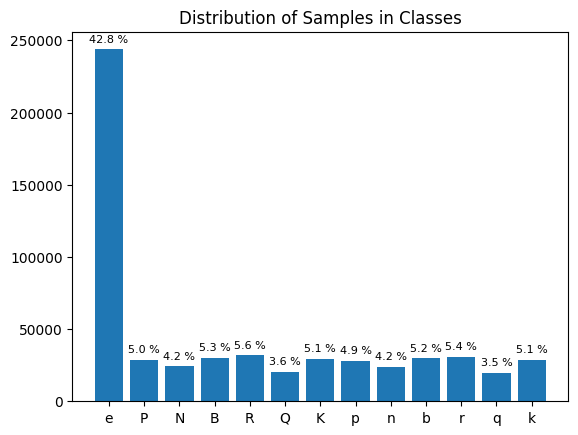

In [6]:
# Samples per class: 42.8% empty squares
# Rest of classes have 3.5 - 5.6 % each

all_labels = []
for x, y in train_data[0]:
    all_labels.append(np.argmax(y, axis=-1))
all_labels = np.concatenate(all_labels, axis=0)

# Plot histogram to visualize class imbalance

label_counts = [np.sum(all_labels == i) for i in range(len(CLASS_NAMES))]

plt.bar(CLASS_NAMES, label_counts)

for i in range(len(CLASS_NAMES)):
    plt.text(x=i,  # x position of the text
             y=label_counts[i] + 5000,  # y position of the text
             s=f'{round(100*label_counts[i] / len(all_labels), 1)} %',
             ha='center',
             fontsize=8)
plt.title("Distribution of Samples in Classes")
# plt.yscale('log')
plt.show()

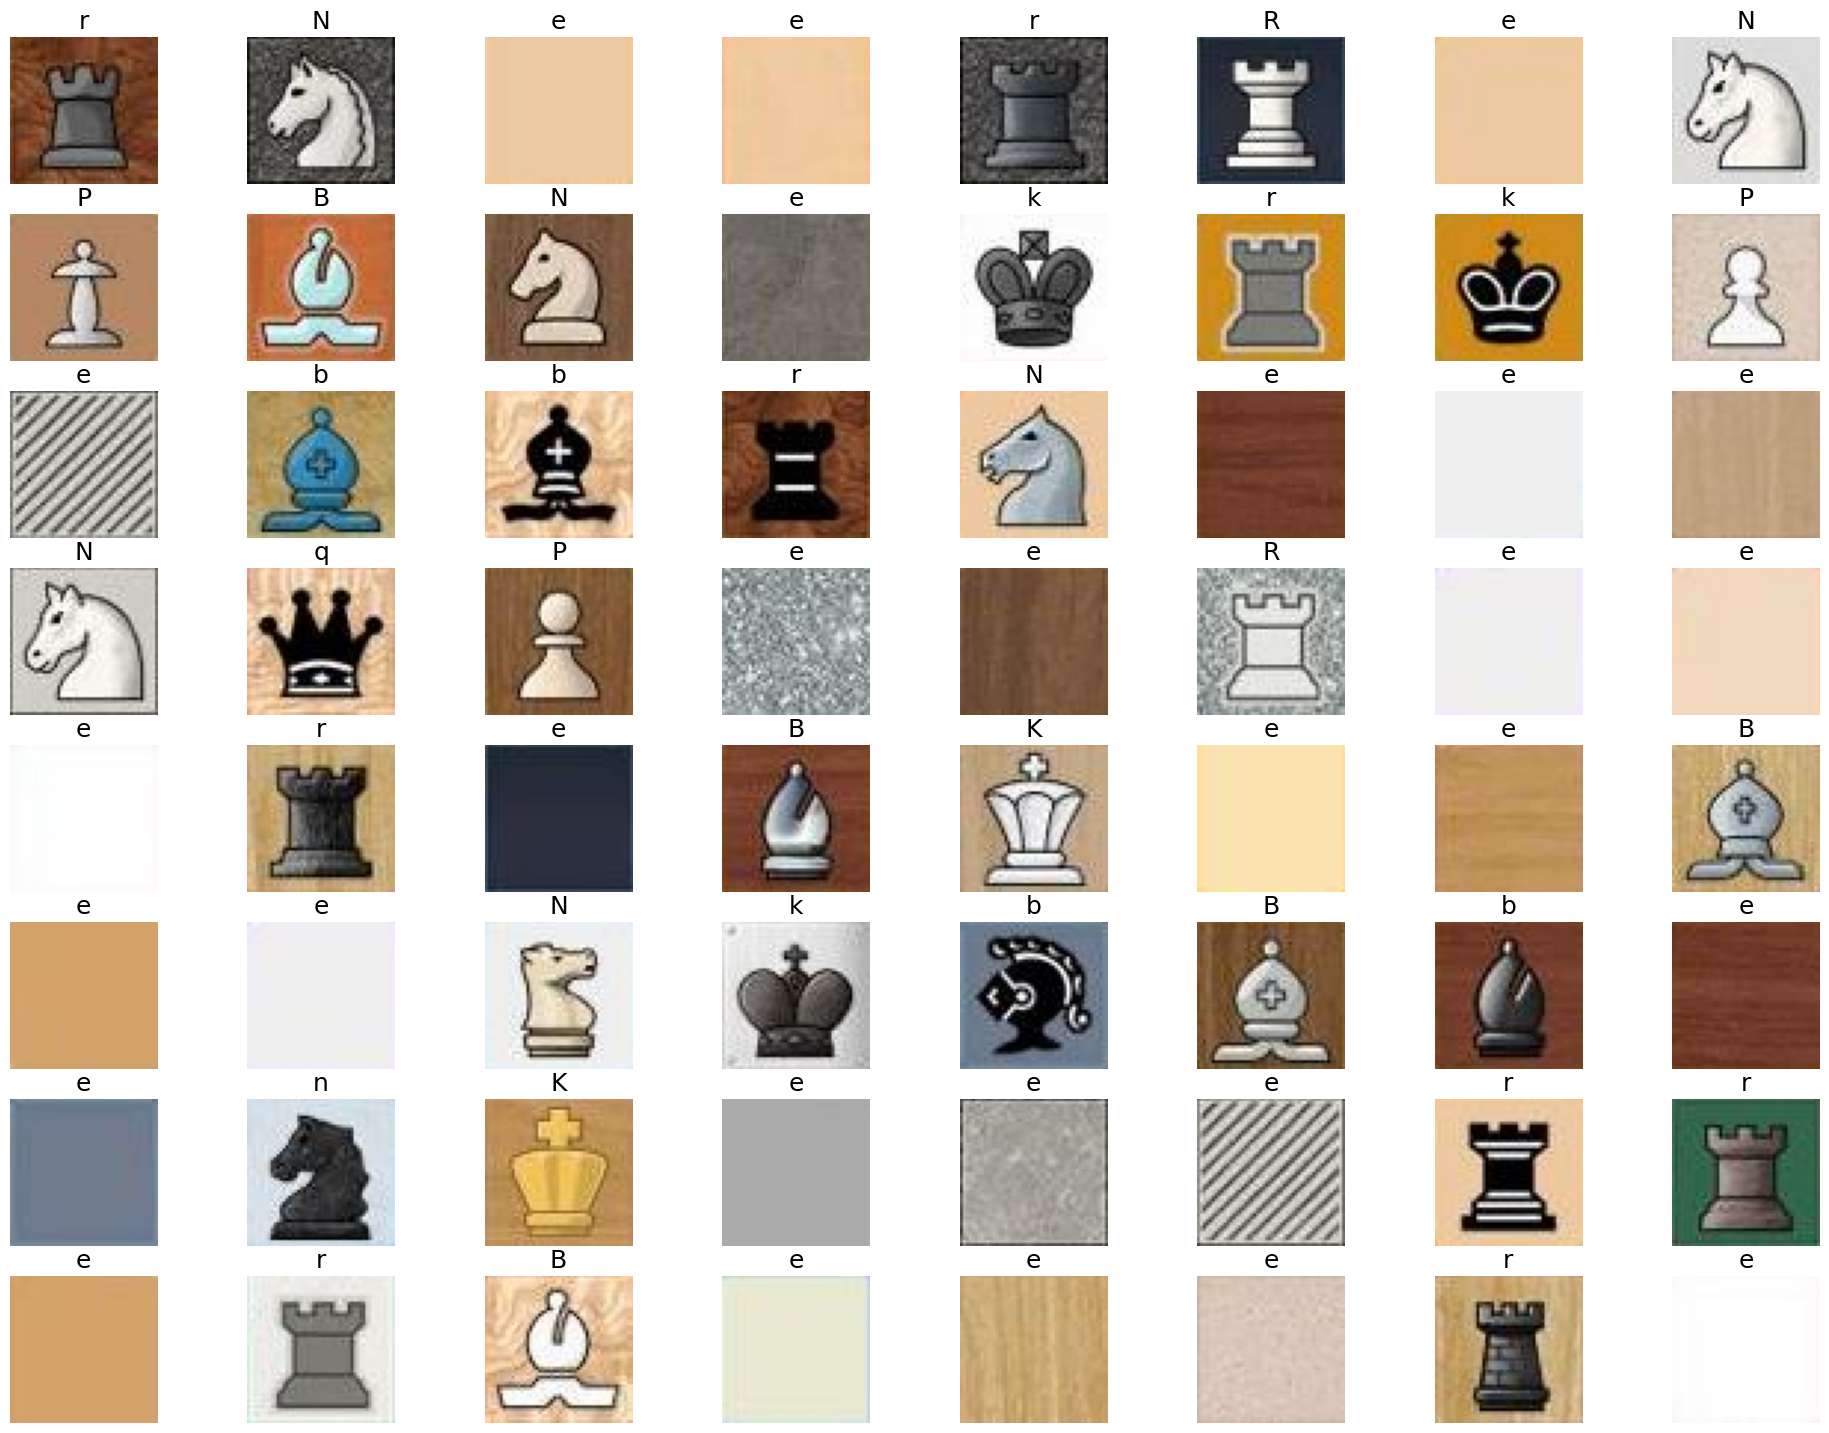

In [12]:
# Show a few chess piece images

plt.figure(figsize=(24, 18))
for images, labels in train_data[0]:
    for i in range(64):
        plt.subplot(8, 8, i+1)
        plt.imshow(images[i].numpy().astype(int))
        label = np.argmax(labels.numpy()[i])
        plt.title(train_data[0].class_names[label], fontsize=18)
        plt.axis('off')
    plt.show()
    break

In [13]:
# Construct the model

model = keras.models.Sequential()
model.add(keras.layers.Input((50, 50, 3)))

model.add(keras.layers.Rescaling(scale=1./255))


model.add(keras.layers.Conv2D(
    filters=18,
    kernel_size=(6, 6),
    strides=(1, 1),
    activation='relu',
    kernel_regularizer=None))  # keras.regularizers.L2(1e-2)


# 45*45*18

model.add(keras.layers.MaxPooling2D(pool_size=(3, 3)))

# 15*15*18

model.add(keras.layers.Conv2D(
    filters=36,
    kernel_size=(4, 4),
    strides=(1, 1),
    activation='relu',
    kernel_regularizer=None)  # keras.regularizers.L2(1e-2)
    )

# 12*12*36

model.add(keras.layers.MaxPooling2D(pool_size=(3, 3)))

# 4*4*36

model.add(keras.layers.Flatten())

# 576

model.add(keras.layers.Dense(
    60,
    activation="relu",
    kernel_regularizer=None)  # keras.regularizers.L2(1e-2)
    )
model.add(keras.layers.Dense(13, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 45, 45, 18)     │         1,962 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 36)     │        10,404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 36)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60)             │        34,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           793 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,779 (186.64 KB)

 Trainable params: 47,779 (186.64 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compile the model

model.compile(
    loss="categorical_crossentropy",
    metrics=["accuracy", "f1_score"],
    optimizer=keras.optimizers.SGD(learning_rate=0.005)
)

In [17]:
# Add class weights

# loss[class] will be multiplied by weight[class]
# => try to make most weights of O(1)

class_weights = 3e4 / np.array(label_counts)
# make most weights O(1)
class_weights = class_weights / np.mean(class_weights[1:])

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: np.float64(0.10871906614850319),
 1: np.float64(0.9219225548083647),
 2: np.float64(1.1001690789781042),
 3: np.float64(0.8790552351665059),
 4: np.float64(0.8307821417609229),
 5: np.float64(1.288039335734303),
 6: np.float64(0.9048021250338119),
 7: np.float64(0.9489893824110449),
 8: np.float64(1.115307109225352),
 9: np.float64(0.8896775460103545),
 10: np.float64(0.8651110859305596),
 11: np.float64(1.338244645599338),
 12: np.float64(0.9178997593413383)}

In [ ]:
# Fit the model

lr_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.5,
    patience=3,
    min_delta=1e-4,
    cooldown=0,
    min_lr=1e-5
)

CHECKPOINT_FILEPATH = os.path.join(
    os.getcwd(),
    "model_checkpoints",
    "ckpt_model_no_dupl_run3.keras"
    )

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_FILEPATH,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
    )

start = time.time()

# on average 140 sec/epoch

history = model.fit(
    train_data[0],
    epochs=3,  # change to higher for actual training
    verbose=True,
    class_weight=class_weights_dict,
    validation_data=train_data[1],
    callbacks=[lr_reduction, model_checkpoint_callback]
)

print(f'Training time = {time.time() - start} sec')

Epoch 1/3
890/890 ━━━━━━━━━━━━━━━━━━━━ 139s 155ms/step - accuracy: 0.4183 - f1_score: 0.3088 - loss: 1.3677 - val_accuracy: 0.7486 - val_f1_score: 0.6045 - val_loss: 1.2927 - learning_rate: 0.0050
Epoch 2/3
890/890 ━━━━━━━━━━━━━━━━━━━━ 139s 156ms/step - accuracy: 0.8628 - f1_score: 0.7875 - loss: 0.5186 - val_accuracy: 0.9256 - val_f1_score: 0.8833 - val_loss: 0.3853 - learning_rate: 0.0050
Epoch 3/3
890/890 ━━━━━━━━━━━━━━━━━━━━ 144s 159ms/step - accuracy: 0.9418 - f1_score: 0.9091 - loss: 0.2170 - val_accuracy: 0.9562 - val_f1_score: 0.9321 - val_loss: 0.2137 - learning_rate: 0.0050
Training time = 422.2689163684845 sec


In [ ]:
# Plot the learning curve

learn_curve = history.history

plt.figure(figsize=(15, 7.5))

plt.subplot(1, 2, 1)
plt.plot(learn_curve['accuracy'], label='Training')
plt.plot(learn_curve['val_accuracy'], label='Validation')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(np.mean(learn_curve['f1_score'], axis=1), label='Training')
plt.plot(np.mean(learn_curve['val_f1_score'], axis=1), label='Validation')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Macro F1 Score')

plt.show()

In [ ]:
#  Save the model

SAVE_MODEL_PATH = os.path.join(
    os.getcwd(),
    "model_checkpoints",
    "chess_pieces.keras"
    )

# model.save(SAVE_MODEL_PATH)